<a href="https://colab.research.google.com/github/kk-shetty/data_science_ik/blob/main/projects/ml_mini_project/node_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Mini Project - **Understanding Networks through Clustering**.
## Leveraging Local Node Features for Structural Profiling

## 1. Data Loading and Library Import

In this section, we import the necessary libraries and load the data into Google Colab from Google Drive. We use the `google.colab.drive` module to access files stored in Google Drive, and the `networkx` and `pandas` libraries for working with network data and data analysis, respectively.


In [ ]:
# Importing necessary libraries
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Mounting Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading edge file
# file_url = '/content/drive/My Drive/ml_mini_project_data/soc-karate.txt'
file_url = '/content/drive/My Drive/ml_mini_project_data/facebook_combined.txt'
network = nx.read_edgelist(file_url)

In [ ]:
# Basic details about the network
print("Number of nodes:", network.number_of_nodes())
print("Number of edges:", network.number_of_edges())

Number of nodes: 4039
Number of edges: 88234


In [ ]:
# Only use for sample files with fewer than 500 nodes

# Plotting the network for visualization
# plt.figure(figsize=(6,6))
# pos = nx.fruchterman_reingold_layout(network)
# pos = nx.kamada_kawai_layout(network)
# pos = nx.random_layout(network)
# nx.draw(network, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='black', linewidths=1, font_size=10)
# plt.title("Graph Visualization")
# plt.show()

## 2. Extracting Local Features from the Network

In this section, we extract local features for each node in the network up to the fourth ego network (radius = 1 to 4). Local features capture the structural properties of the network neighborhood around each node, providing insights into its immediate connectivity and topology.

### Functions Used:

#### `extract_local_features(local_network, node, radius)`

This function computes various local features for a given node within its ego network of a specified radius. It calculates properties such as clustering coefficient, ego network size, density, number of triangles (closed triangles), number of bridges, centrality properties (radius, diameter, center), cycle basis count, and cycle counts of different lengths up to 6. The function returns a dictionary containing these features.

#### Usage:

We utilize the `extract_local_features` function to extract local features for each node in the network up to the fourth ego network. For each node, we iterate over ego networks of increasing radius, compute the local features using the function, and store the results in a dictionary.

### Steps:

1. **Iterate Over Nodes**: We iterate over each node in the network.
2. **Compute Local Features**: For each node, we compute local features within ego networks of radius 1 to 4 using the `extract_local_features` function.
3. **Create DataFrame**: We construct a pandas DataFrame from the computed local features dictionary, with nodes as rows and features as columns.

### Result:

The resulting DataFrame contains local features for each node, where each row represents a node and each column represents a local feature. This DataFrame serves as the basis for further analysis and modeling tasks, such as clustering nodes based on their structural similarities.

Let's take a sample of 20 rows from the DataFrame to examine the extracted local features.


In [ ]:
# Using tqdm package to track the progress
from tqdm import tqdm

In [ ]:
def extract_local_features(args):
    local_network, node, radius = args
    features = {}

    if radius == 1:
        features['node_clustering_coefficient'] = nx.clustering(local_network, node)

    features[f'EN{radius}_number_of_nodes'] = local_network.number_of_nodes()
    features[f'EN{radius}_number_of_edges'] = local_network.number_of_edges()
    features[f'EN{radius}_ego_density'] = nx.density(local_network)

    features[f'EN{radius}_triangles_count'] = sum(nx.triangles(local_network).values()) // 3

    features[f'EN{radius}_bridges_count'] = len(list(nx.bridges(local_network)))

    features[f'EN{radius}_is_center'] = 1 if node in nx.center(local_network) else 0
    features[f'EN{radius}_radius'] = nx.radius(local_network)
    features[f'EN{radius}_diameter'] = nx.diameter(local_network)

    cycle_basis_lengths = [len(cycle) for cycle in nx.cycle_basis(local_network)]
    features[f'EN{radius}_cycle_basis_count'] = len(cycle_basis_lengths)
    features[f'EN{radius}_max_cycle_basis'] = max(cycle_basis_lengths, default=0)

    return features

In [ ]:
# Using the above function to extract the local featrures for 1st ego network and creating a data frame using all the features as columns.
def ego_network_features(ego_radius):
    local_features = {}

    for node in tqdm(network.nodes(), desc="Processing nodes", unit="node"):
        local_features[node] = {}
        ego_network = nx.ego_graph(network, node, radius=ego_radius)
        local_features[node].update(extract_local_features((ego_network, node, ego_radius)))

    # Creating pandas dataframe from the features dictionary and saving into csv
    df = pd.DataFrame.from_dict(local_features, orient='index')
    df.index.name = 'node'
    df.reset_index(inplace=True)

    # Specify the path where you want to save the file in your Google Drive
    file_path = f'/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_{ego_radius}.csv'

    # Save the DataFrame to CSV without row index
    df.to_csv(file_path, index=False)

In [ ]:
# Calling the function to extract local features of different ego network.
ego_network_features(1)

Processing nodes: 100%|██████████| 4039/4039 [03:30<00:00, 19.21node/s] 


## 3. Feature Engineering

In [ ]:
# Checking unque values for each of the features
df.nunique()

node                           34
node_clustering_coefficient    13
EN1_number_of_nodes            11
EN1_number_of_edges            15
EN1_ego_density                15
EN1_triangles_count            13
EN1_bridges_count               4
EN1_is_center                   1
EN1_radius                      1
EN1_diameter                    2
EN1_cycle_basis_count          13
EN1_max_cycle_basis             2
EN1_cycle_of_4                 13
EN1_cycle_of_5                 10
EN1_cycle_of_6                  8
EN2_number_of_nodes            14
EN2_number_of_edges            18
EN2_ego_density                18
EN2_triangles_count            17
EN2_bridges_count               4
EN2_is_center                   2
EN2_radius                      2
EN2_diameter                    3
EN2_cycle_basis_count          15
EN2_max_cycle_basis             4
EN2_cycle_of_4                 20
EN2_cycle_of_5                 20
EN2_cycle_of_6                 20
EN3_number_of_nodes             6
EN3_number_of_

In [ ]:
# Let's remove feature with constant values
columns_to_drop = ['EN1_is_center', 'EN1_radius', 'EN4_bridges_count']
# df.drop(columns=['EN1_is_center', 'EN1_radius', 'EN4_bridges_count'], inplace=True)

In [ ]:
# Value counts of features with low variance
df[['EN1_diameter', 'EN1_max_cycle_basis', 'EN2_is_center', 'EN2_radius', 'EN2_diameter', 'EN3_is_center', 'EN3_radius', 'EN3_diameter', 'EN4_is_center', 'EN4_radius', 'EN4_diameter']].apply(pd.Series.value_counts)

,EN1_diameter,EN1_max_cycle_basis,EN2_is_center,EN2_radius,EN2_diameter,EN3_is_center,EN3_radius,EN3_diameter,EN4_is_center,EN4_radius,EN4_diameter
0,NaN,2.0,3.0,NaN,NaN,25.0,NaN,NaN,26.0,NaN,NaN
1,12.0,NaN,31.0,3.0,NaN,9.0,NaN,NaN,8.0,NaN,NaN
2,22.0,NaN,NaN,31.0,4.0,NaN,25.0,NaN,NaN,9.0,NaN
3,NaN,32.0,NaN,NaN,19.0,NaN,9.0,2.0,NaN,25.0,NaN
4,NaN,NaN,NaN,NaN,11.0,NaN,NaN,23.0,NaN,NaN,9.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,25.0


In [ ]:
# add columns to drop
columns_to_drop.extend(['EN1_max_cycle_basis', 'EN2_is_center', 'EN2_radius'])

In [ ]:
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Performing correlation analysis between ego network 1 features

# Importing seaborn library to plot correlation matrix
import seaborn as sns

en1_features = df.columns[2:12]

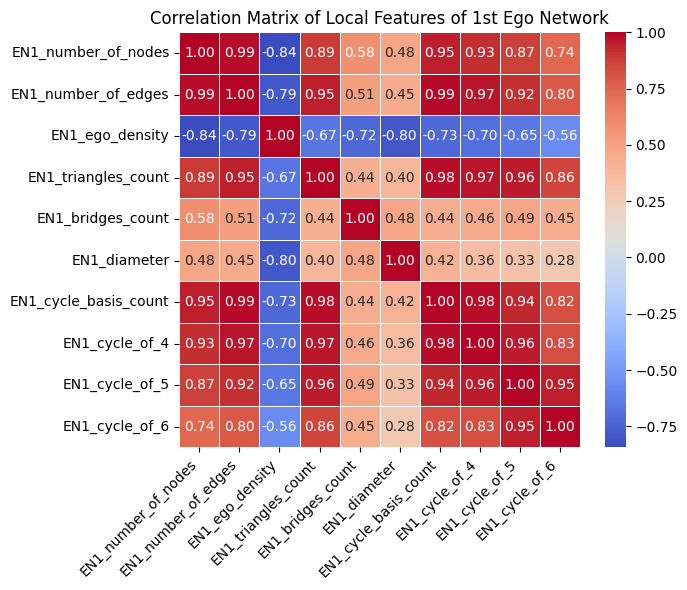

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df[en1_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 1st Ego Network')
plt.tight_layout()
plt.show()